In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import scipy.io
import numpy as np
import lhsmdu

In [17]:
from matplotlib import rcParams
rcParams.update({
    "font.size": 14})

## Load in FEM Validation Data

In [3]:
burgers = scipy.io.loadmat('matlab/burgers.mat')
X_ = torch.from_numpy(burgers['X']).reshape(-1).float()
T_ = torch.from_numpy(burgers['T']).reshape(-1).float()
u_ = torch.from_numpy(burgers['u']).reshape(-1).float()
X_.requires_grad = True
T_.requires_grad = True
xmin = X_.min()
xmax = X_.max()
N_x = X_.shape[0]

In [4]:
X_.shape, T_.shape, u_.shape

(torch.Size([301]), torch.Size([101]), torch.Size([30401]))

In [5]:
u_ = u_.reshape(X_.shape[0], T_.shape[0])

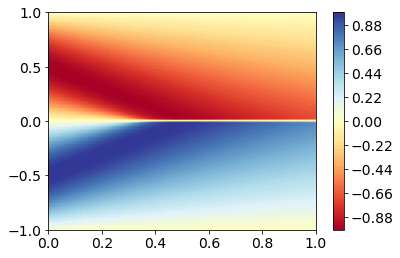

In [6]:
## Evaluate network
x_, t_ = torch.meshgrid(X_, T_)
plt.contourf(t_.detach(), x_.detach(), u_.detach(), levels=100, cmap='RdYlBu')
plt.colorbar()
plt.show()

In [7]:
x_eval = x_.reshape(-1, 1)
t_eval = t_.reshape(-1, 1)

## Defining the function and solution

In [8]:
import numpy as np

In [9]:
pi = torch.tensor(np.pi)

In [10]:
nu = 1/(100*pi)
_u_i = lambda x: -torch.sin(pi*x)
_u_b = lambda t: 0*t

In [11]:
n_x = 20 # Number of data points in interior domain
n_i = 10 # Number of initial points
n_b = 10 # Number of boundary (time) points
n_t = 20
xmin = -1
xmax = 1

# Interior of domain
X = torch.linspace(xmin, xmax, n_x+2, requires_grad=True)[1:-1]
T = torch.linspace(0, 1, n_t+1, requires_grad=True)[1:]
x, t = torch.meshgrid((X, T))
x = x.reshape(-1, 1)
t = t.reshape(-1, 1)

# Initial
x_i = torch.linspace(xmin, xmax, n_i,requires_grad=True).reshape(-1, 1)[1:-1]
t_i = torch.zeros(x_i.shape, requires_grad=True)
u_i = _u_i(x_i)

# Boundary
x_b = torch.cat((xmin*torch.ones(n_b, 1, requires_grad=True),
                 xmax*torch.ones(n_b, 1, requires_grad=True)))
t_b = torch.cat((torch.linspace(0, 1, n_b, requires_grad=True),
                torch.linspace(0, 1, n_b, requires_grad=True)), dim=0).reshape(-1, 1)
u_b = _u_b(t_b)

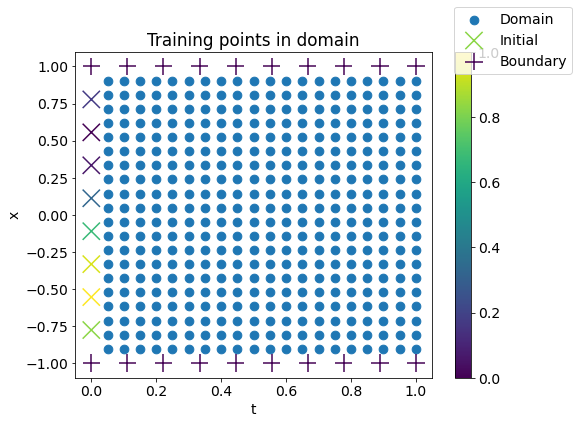

In [12]:
fig, ax = plt.subplots(figsize=(8,6))
d = ax.scatter(t.detach(), x.detach(), marker='.', s=300, label='Domain')
i = ax.scatter(t_i.detach(), x_i.detach(), c=u_i.detach(), marker='x', s=300, label='Initial')
b = ax.scatter(t_b.detach(), x_b.detach(), c=u_b.detach(), marker='+', s=300, label='Boundary')
fig.colorbar(d)
fig.legend()
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.set_title('Training points in domain')
plt.show()

In [27]:
class Net(nn.Module):
    def __init__(self,
        N_in, N_out,
        N_hid = 30, N_layers=3,
        loss_func=nn.MSELoss(),
        learning_rate = 0.01,
        optimizer = optim.Adam,
        act_func=nn.Tanh()
                ):
        
        super(Net, self).__init__()
        self.loss_func = loss_func

        # Initialise layers
        layers = [nn.Linear(in_features=N_in,
                    out_features=N_hid,
                    bias=True), act_func]
        for _ in range(N_layers - 1):
            layers += [nn.Linear(in_features=N_hid,
                    out_features=N_hid,
                    bias=True), act_func]
        layers += [nn.Linear(in_features=N_hid,
                    out_features=N_out,
                    bias=True)]

        self.layers = nn.Sequential(*layers)
        self.optimizer = optimizer(self.parameters(), lr=learning_rate)
        
        # Save hyperparameters
        self.N_hid = N_hid
        self.N_layers = N_layers
        self.act_func = act_func
        self.learning_rate = learning_rate
        self.N_params = sum([p.numel() for p in self.parameters()])
        
        
        self.previous_loss = torch.tensor((1.0, 1.0, 1.0))
        
    def forward(self, x, t):
        x = torch.cat((x, t), dim=1)
        out = self.layers(x)
        return out
    
    def PDE(self, x, t):
        u_hat = self.forward(x, t)
        u_x_hat = torch.autograd.grad(u_hat, x, torch.ones(x.shape), create_graph=True)[0]
        u_xx_hat = torch.autograd.grad(u_x_hat, x, torch.ones(x.shape), create_graph=True)[0]
        u_t_hat = torch.autograd.grad(u_hat, t, torch.ones(t.shape), create_graph=True)[0]
        
        pde = nu*u_xx_hat - u_hat*u_x_hat - u_t_hat.reshape(u_x_hat.shape)
        return pde
    
    def loss_BC(self, x_b, t_b, u_b):
        u_b_hat = self.forward(x_b, t_b)
        loss = self.loss_func(u_b, u_b_hat.reshape(u_b.shape))
        return loss
    
    def loss_IC(self, x_i, t_i, u_i):
        u_i_hat = self.forward(x_i, t_i)
        loss = self.loss_func(u_i, u_i_hat.reshape(u_i.shape))
        return loss

    def loss_PDE(self, x, t):
        pde = self.PDE(x, t)
        loss = self.loss_func(pde, torch.zeros(pde.shape, requires_grad=True))
        return loss
    
    def loss(self, x, t, x_b, t_b, u_b, x_i, t_i, u_i):
        current_loss_PDE = self.loss_PDE(x, t)
        current_loss_BC = self.loss_BC(x_b, t_b, u_b)
        current_loss_IC = self.loss_IC(x_i, t_i, u_i)
        current_loss = torch.tensor([current_loss_PDE, current_loss_BC, current_loss_IC], requires_grad=True)
        ratio = current_loss/self.previous_loss
        self.lam = torch.softmax(ratio - max(ratio), 0).detach()
        self.previous_loss = current_loss
        true_loss = current_loss_PDE + current_loss_BC + current_loss_IC
        weighted_loss = self.lam[0]*current_loss_PDE + self.lam[1]*current_loss_BC + self.lam[2]*current_loss_IC
        return weighted_loss, true_loss

    
    def step(self, x, t, x_b, t_b, u_b, x_i, t_i, u_i, use_weighted_loss=True):
        self.train()
        self.optimizer.zero_grad()
        weighted_loss, true_loss = self.loss(x, t, x_b, t_b, u_b, x_i, t_i, u_i)
        if use_weighted_loss:
            weighted_loss.backward(retain_graph=True)
        else:
            true_loss.backward(retain_graph=True)
        self.optimizer.step()
        self.eval()
        return true_loss.detach().item()

In [28]:
def MSE(net, u_, x, t):
    u = u_.detach().reshape(-1,1)
    u_hat = net(x,t).detach().reshape(-1,1)
    MSE = torch.mean((u - u_hat)**2)
    return MSE

In [29]:
def progress(i, total):
    print("\r", '{:.2f}% '.format((i+1)*100/total), end="")

In [30]:
def random(n, n_i, n_b):
    cube = lhsmdu.createRandomStandardUniformMatrix(2, n*n)
    x = torch.from_numpy(cube[0, :]).reshape(-1, 1)*(xmax-xmin) + xmin
    t = torch.from_numpy(cube[1, :]).reshape(-1, 1)
    x = x.float()
    t = t.float()
    x.requires_grad = True
    t.requires_grad = True
    
    # initial
    x_i = torch.from_numpy(lhsmdu.createRandomStandardUniformMatrix(1, n_i)[0, :]).reshape(-1, 1)*(xmax - xmin) + xmin
    x_i.requires_grad=True
    x_i = x_i.float()
    t_i = torch.zeros(x_i.shape, requires_grad=True)
    u_i = _u_i(x_i)
    
    # boundary
    x_b = torch.cat((xmin*torch.ones(n_b, 1, requires_grad=True),
                     xmax*torch.ones(n_b, 1, requires_grad=True))).float()
    t_b = torch.from_numpy(lhsmdu.createRandomStandardUniformMatrix(1, n_b)[0, :]).reshape(-1, 1)
    t_b = torch.cat((t_b, t_b)).float()
    t_b.requires_grad=True
    u_b = _u_b(t_b)
    
    return x, t, x_i, t_i, u_i, x_b, t_b, u_b
    

In [41]:
epochs = 10000
loss_training, loss_validation = torch.zeros(2, epochs), torch.zeros(2,epochs)
loss_data = torch.zeros(2, epochs)
N_hid = 30
N_layers = 3
n_val = 20
n_i_val = 10
n_b_val = 10
x_val, t_val, x_i_val, t_i_val, u_i_val, x_b_val, t_b_val, u_b_val = random(n_val, n_i_val, n_b_val)
use_weighted_loss_ = [True, False]
for k, use_weighted_loss in enumerate(use_weighted_loss_):
    net = Net(N_in=2, N_out=1, N_hid=N_hid, N_layers=N_layers)
    for e in range(epochs):
        loss_training[k, e] = net.step(x, t, x_b, t_b, u_b, x_i, t_i, u_i, use_weighted_loss=use_weighted_loss)
        loss_data[k, e] = MSE(net, u_, x_eval, t_eval)
        _, _loss_validation = net.loss(x_val, t_val, x_i_val, t_i_val, u_i_val, x_b_val, t_b_val, u_b_val)
        loss_validation[k, e] = _loss_validation.detach().item()
        progress(e, epochs)
        if (e+1)%500 == 0:
            print('\nEpoch: {:d}. data loss: {:.3f}. physics loss: {:.3f}. validation loss: {:.3f}'.format(e+1, loss_data[k,e], loss_training[k,e], loss_validation[k,e]))

 5.00% 
Epoch: 500. data loss: 0.038. physics loss: 0.115. validation loss: 0.245
 10.00% 
Epoch: 1000. data loss: 0.050. physics loss: 0.122. validation loss: 0.208
 15.00% 
Epoch: 1500. data loss: 0.041. physics loss: 0.131. validation loss: 0.152
 20.00% 
Epoch: 2000. data loss: 0.052. physics loss: 0.080. validation loss: 0.182
 25.00% 
Epoch: 2500. data loss: 0.076. physics loss: 0.013. validation loss: 0.550
 30.00% 
Epoch: 3000. data loss: 0.089. physics loss: 0.004. validation loss: 0.769
 35.00% 
Epoch: 3500. data loss: 0.092. physics loss: 0.002. validation loss: 0.805
 40.00% 
Epoch: 4000. data loss: 0.094. physics loss: 0.001. validation loss: 0.793
 45.00% 
Epoch: 4500. data loss: 0.095. physics loss: 0.001. validation loss: 0.754
 50.00% 
Epoch: 5000. data loss: 0.130. physics loss: 0.199. validation loss: 0.173
 55.00% 
Epoch: 5500. data loss: 0.051. physics loss: 0.040. validation loss: 0.663
 60.00% 
Epoch: 6000. data loss: 0.084. physics loss: 0.022. validation loss: 

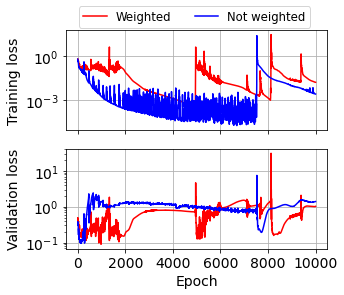

In [46]:
fig, ax = plt.subplots(2, figsize=(5,4), sharex=True)
for k, use_weighted_loss, color in zip([0, 1], use_weighted_loss_, ['red', 'blue']):
    ax[0].semilogy(loss_training[k, :], color=color, label=['Weighted' if use_weighted_loss else 'Not weighted'][0])
    ax[1].semilogy(loss_validation[k, :], color=color)
fig.legend(ncol=2, fontsize='small', bbox_to_anchor=(0.9, 1.05))
ax[0].set_ylabel('Training loss')
ax[1].set_ylabel('Validation loss')
ax[0].grid()
ax[1].grid()
ax[1].set_xlabel('Epoch')
fig.tight_layout()
fig.savefig('./figs/burger_scaling_vs_no_scaling.png', dpi=600, bbox_inches='tight')
    